### 시스템 아키텍처

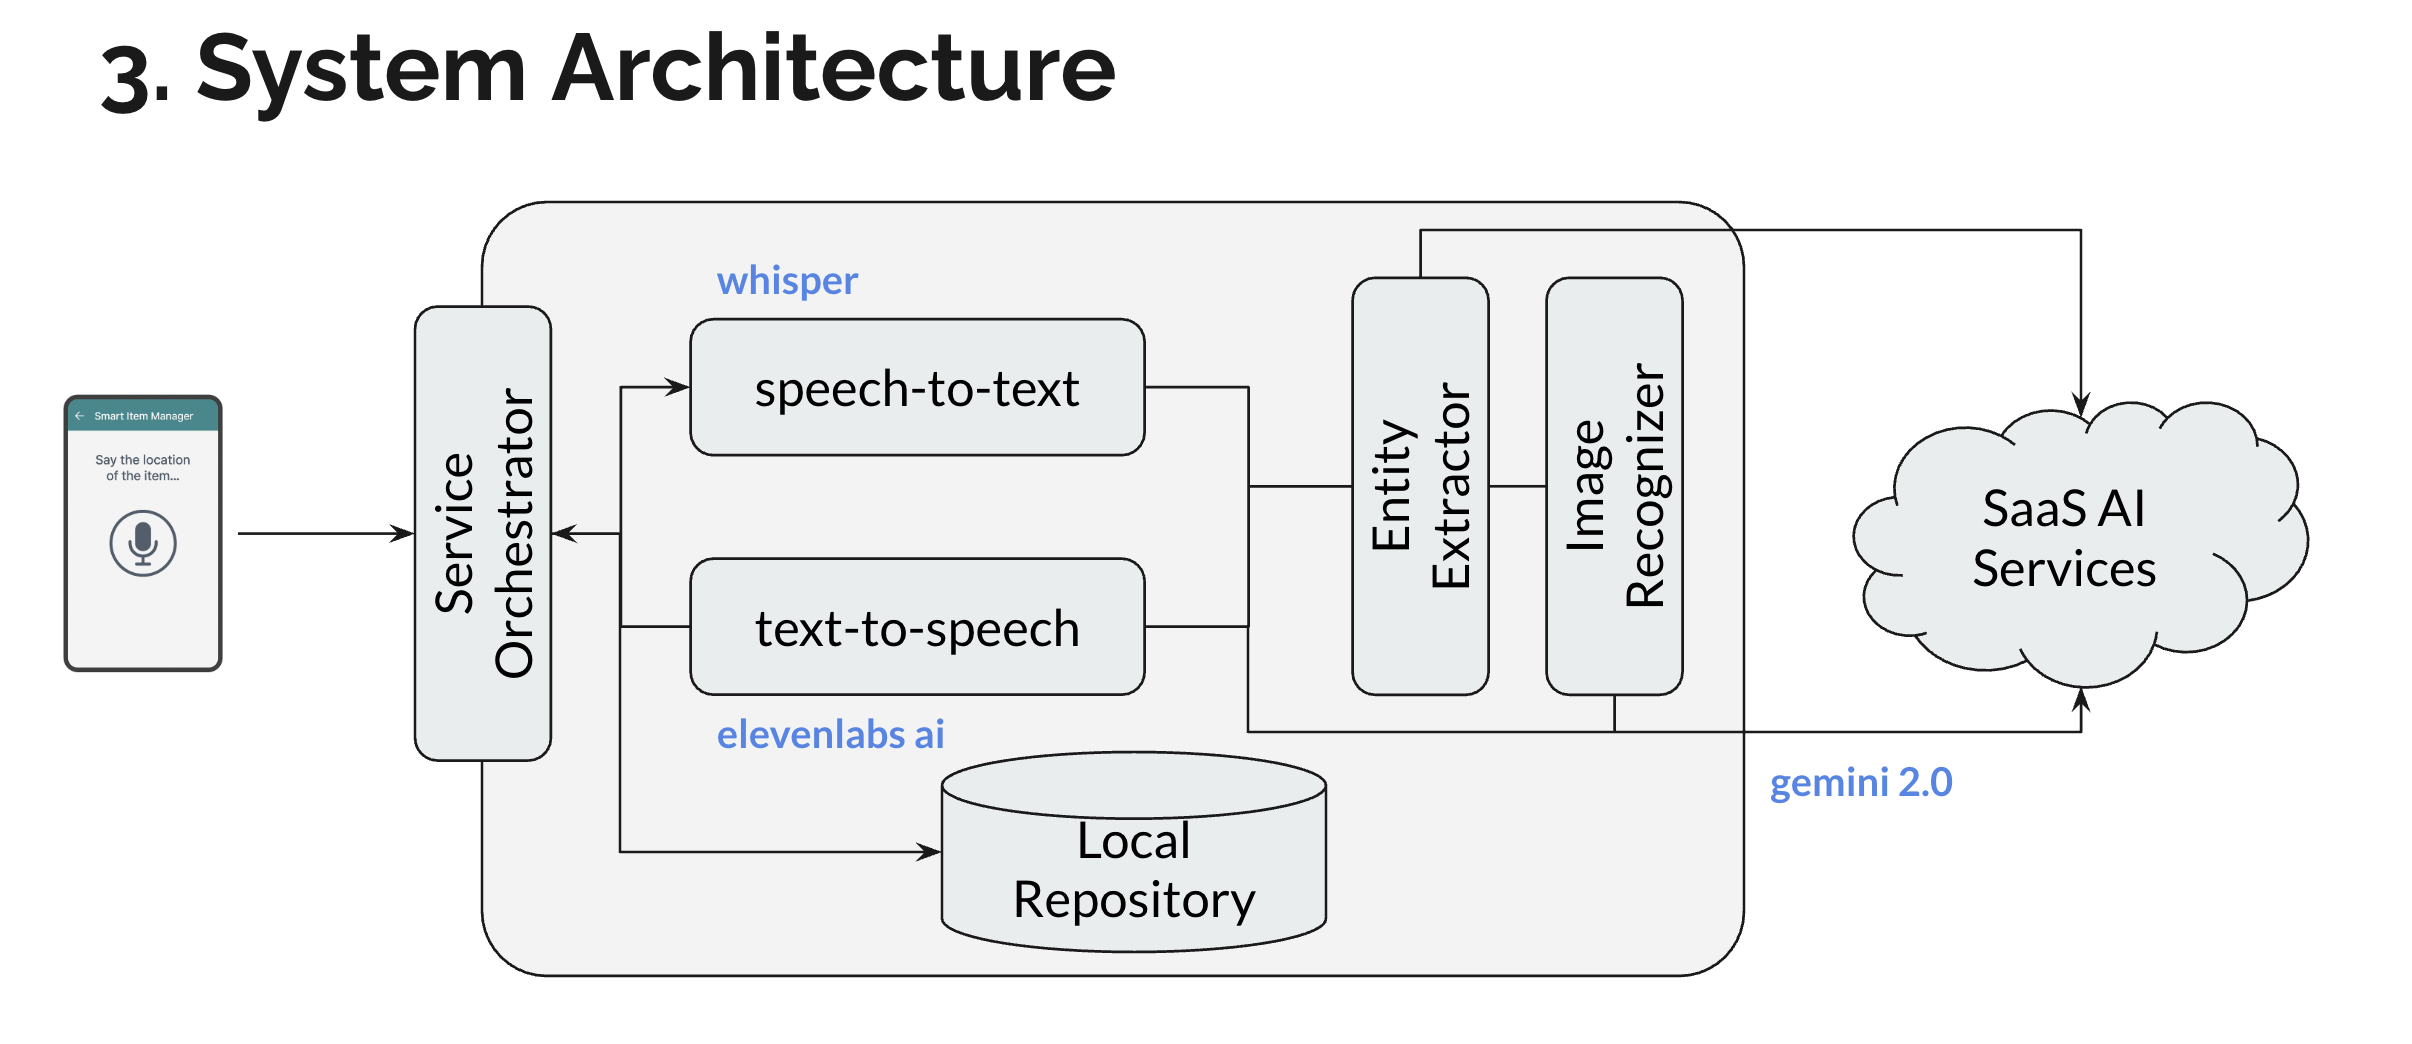

In [81]:
from PIL import Image 
Image.open('images/architecture.png')

### 위치저장 기능 구현 speech-to-text

In [29]:
import time
import requests
import whisper
import os


def transcribe_file(job_name, file_uri, transcribe_client=None):
    # Whisper 모델 로드
    model = whisper.load_model("turbo")
    
    # 파일 경로 처리
    if file_uri.startswith(('http://', 'https://')):
        # URL인 경우 다운로드
        response = requests.get(file_uri)
        audio_path = "temp_audio.wav"
        with open(audio_path, "wb") as f:
            f.write(response.content)
    else:
        # 로컬 파일인 경우
        audio_path = file_uri
    
    # Whisper로 음성 인식
    result = model.transcribe(audio_path, language="ko")
    
    # 임시 파일 삭제
    if file_uri.startswith(('http://', 'https://')) and os.path.exists(audio_path):
        os.remove(audio_path)
    
    return result["text"]

### 로컬 음성 녹음 파일 저장

In [30]:
import sounddevice as sd
import soundfile as sf
import numpy as np
from datetime import datetime
import os

def record_audio(duration=5, sample_rate=44100, channels=1):
    """
    마이크로부터 음성을 녹음합니다.
    
    Args:
        duration (int): 녹음할 시간(초)
        sample_rate (int): 샘플링 레이트
        channels (int): 채널 수 (1: 모노, 2: 스테레오)
    
    Returns:
        tuple: (오디오 데이터, 샘플링 레이트)
    """
    print(f"{duration}초 동안 녹음을 시작합니다...")
    recording = sd.rec(
        int(duration * sample_rate),
        samplerate=sample_rate,
        channels=channels,
        dtype='float32'
    )
    sd.wait()  # 녹음이 끝날 때까지 대기
    print("녹음이 완료되었습니다!")
    return recording, sample_rate

def save_audio(recording, sample_rate, filename=None, directory="recordings"):
    """
    녹음된 오디오를 WAV 파일로 저장합니다.
    
    Args:
        recording (numpy.ndarray): 녹음된 오디오 데이터
        sample_rate (int): 샘플링 레이트
        filename (str, optional): 저장할 파일명. 기본값은 현재 시간을 사용
        directory (str, optional): 저장할 디렉토리. 기본값은 'recordings'
    
    Returns:
        str: 저장된 파일의 전체 경로
    """
    # 저장 디렉토리가 없으면 생성
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    if filename is None:
        # 현재 시간을 파일명으로 사용
        filename = f"audio_{datetime.now().strftime('%Y%m%d_%H%M%S')}.wav"
    
    # 전체 경로 생성
    filepath = os.path.join(directory, filename)
    
    # WAV 파일로 저장
    sf.write(filepath, recording, sample_rate)
    print(f"파일이 저장되었습니다: {filepath}")
    
    return filepath

def record_and_save(duration=5, sample_rate=44100, channels=1, filename=None):
    """
    음성을 녹음하고 바로 WAV 파일로 저장합니다.
    
    Args:
        duration (int): 녹음할 시간(초)
        sample_rate (int): 샘플링 레이트
        channels (int): 채널 수 (1: 모노, 2: 스테레오)
        filename (str, optional): 저장할 파일명. 기본값은 현재 시간을 사용
    
    Returns:
        str: 저장된 파일의 전체 경로
    """
    recording, sample_rate = record_audio(duration, sample_rate, channels)
    return save_audio(recording, sample_rate, filename)

### 위치 음성 인식 저장 및 검색 구현 text-to-speech

In [37]:
import json
from datetime import datetime
import os
from google import genai
from elevenlabs.client import ElevenLabs
from elevenlabs import play
# os.environ["PATH"] = "/opt/homebrew/bin:" + os.environ.get("PATH", "")

def get_gemini_response(text):
    """
    Gemini API를 사용하여 텍스트에서 객체와 위치 정보를 추출합니다.
    
    Args:
        text (str): 분석할 텍스트
    
    Returns:
        dict: 추출된 객체와 위치 정보
    """
    client = genai.Client(api_key="")
    
    question = f"""다음의 문장에서 사물과 위치를 찾아서 바로 로딩하여 저장할 수 있도록 다음과 같이 json 형식으로만 출력해주세요
    {{
      "name": "가방",
      "location": "책상 위"
    }}
    {text}"""
    
    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=question
    )
    
    # JSON 문자열에서 실제 JSON 객체 추출
    try:
        # ```json과 ``` 제거
        json_str = response.text.replace("```json", "").replace("```", "").replace("[", "").replace("]", "").strip()
        return json.loads(json_str)
    except:
        return {"name": "", "location": ""}

def save_transcription(text, filename=None, directory="transcriptions"):
    """
    음성 인식 결과를 JSON 파일로 저장합니다.
    
    Args:
        text (str): 저장할 텍스트
        filename (str, optional): 저장할 파일명. 기본값은 현재 시간을 사용
        directory (str, optional): 저장할 디렉토리. 기본값은 'transcriptions'
    
    Returns:
        str: 저장된 파일의 전체 경로
    """
    # 저장 디렉토리가 없으면 생성
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    if filename is None:
        # 현재 시간을 파일명으로 사용
        filename = f"transcription_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    
    # 전체 경로 생성
    filepath = os.path.join(directory, filename)
    
    # Gemini API로 객체 정보 추출
    object_info = get_gemini_response(text)
    
    # 데이터 구조화
    data = {
        "text": text,
        "timestamp": datetime.now().isoformat(),
        "objects": [[object_info]]  # Gemini API에서 추출한 객체 정보 저장
    }
    
    # 파일로 저장
    with open(filepath, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)
    
    return filepath

def load_transcription(filepath):
    """
    저장된 음성 인식 결과를 불러옵니다.
    
    Args:
        filepath (str): 불러올 파일의 경로
    
    Returns:
        dict: 저장된 데이터
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        return json.load(f)

def list_transcriptions(directory="transcriptions"):
    """
    저장된 모든 음성 인식 결과 파일 목록을 반환합니다.
    
    Args:
        directory (str, optional): 검색할 디렉토리. 기본값은 'transcriptions'
    
    Returns:
        list: 파일 경로 목록
    """
    if not os.path.exists(directory):
        return []
    
    return [os.path.join(directory, f) for f in os.listdir(directory) 
            if f.endswith('.json')]

def speak_response(text):
    """
    텍스트를 음성으로 변환하여 재생합니다.
    
    Args:
        text (str): 음성으로 변환할 텍스트
    """
    elevenlabs = ElevenLabs(
        api_key=""
    )
    
    audio = elevenlabs.text_to_speech.convert(
        text=text,
        voice_id="JBFqnCBsd6RMkjVDRZzb",
        model_id="eleven_multilingual_v2",
        output_format="mp3_44100_128",
    )
    
    play(audio)

def search_object_location(object_name, directory="transcriptions", speak=True):
    """
    저장된 JSON 파일들에서 특정 물건의 위치를 검색합니다.
    
    Args:
        object_name (str): 찾을 물건의 이름
        directory (str, optional): 검색할 디렉토리. 기본값은 'transcriptions'
        speak (bool, optional): 결과를 음성으로 출력할지 여부. 기본값은 True
    
    Returns:
        dict: 검색 결과
            {
                "found": bool,  # 물건을 찾았는지 여부
                "location": str,  # 물건의 위치
                "timestamp": str,  # 기록된 시간
                "source_file": str  # 출처 파일
            }
    """
    if not os.path.exists(directory):
        result = {"found": False, "location": "", "timestamp": "", "source_file": ""}
        if speak:
            speak_response(f"{object_name}의 위치를 찾을 수 없습니다.")
        return result
    
    # 디렉토리의 모든 JSON 파일 검색
    for filename in os.listdir(directory):
        if not filename.endswith('.json'):
            continue
            
        filepath = os.path.join(directory, filename)
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                data = json.load(f)
                
            # objects 배열에서 물건 검색 (이중 배열 구조 처리)
            objects = data.get('objects', [])
            if isinstance(objects, list) and len(objects) > 0:
                # 첫 번째 배열의 객체들 검색
                for obj in objects[0]:
                    if isinstance(obj, dict) and obj.get('name', '').lower() == object_name.lower():
                        result = {
                            "found": True,
                            "location": obj.get('location', ''),
                            "timestamp": data.get('timestamp', ''),
                            "source_file": filename
                        }
                        if speak:
                            speak_response(f"{object_name}은 {result['location']}에 있습니다.")
                        return result
        except Exception as e:
            print(f"파일 {filename} 읽기 실패: {str(e)}")
            continue
    
    result = {"found": False, "location": "", "timestamp": "", "source_file": ""}
    if speak:
        speak_response(f"{object_name}의 위치를 찾을 수 없습니다.")
    return result

def search_all_objects(directory="transcriptions", speak=True):
    """
    저장된 모든 물건과 위치 정보를 반환합니다.
    같은 물건이 여러 번 기록된 경우, 가장 최근의 위치 정보만 반환합니다.
    
    Args:
        directory (str, optional): 검색할 디렉토리. 기본값은 'transcriptions'
        speak (bool, optional): 결과를 음성으로 출력할지 여부. 기본값은 True
    
    Returns:
        list: 물건과 위치 정보 목록 (각 물건의 최신 정보만 포함)
    """
    if not os.path.exists(directory):
        if speak:
            speak_response("저장된 물건 정보가 없습니다.")
        return []
    
    # 물건별로 최신 정보를 저장할 딕셔너리
    latest_objects = {}
    
    # 디렉토리의 모든 JSON 파일 검색
    for filename in os.listdir(directory):
        if not filename.endswith('.json'):
            continue
            
        filepath = os.path.join(directory, filename)
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                data = json.load(f)
                
            # objects 배열의 모든 물건 정보 수집 (이중 배열 구조 처리)
            objects_list = data.get('objects', [])
            if isinstance(objects_list, list) and len(objects_list) > 0:
                for obj in objects_list[0]:
                    if isinstance(obj, dict):
                        name = obj.get('name', '')
                        if name:  # 이름이 있는 경우만 처리
                            current_timestamp = data.get('timestamp', '')
                            # 이미 저장된 정보가 없거나, 현재 정보가 더 최신인 경우 업데이트
                            if name not in latest_objects or current_timestamp > latest_objects[name]['timestamp']:
                                latest_objects[name] = {
                                    "name": name,
                                    "location": obj.get('location', ''),
                                    "timestamp": current_timestamp,
                                    "source_file": filename
                                }
        except Exception as e:
            print(f"파일 {filename} 읽기 실패: {str(e)}")
            continue
    
    # 딕셔너리의 값들을 리스트로 변환
    objects = list(latest_objects.values())
    return objects 

### 사진 업로드 위치 인식 image recognizer

In [32]:
def extractImage(image_path, text="주차"):
    """
    이미지에서 정보를 추출하여 JSON 파일로 저장합니다.
    
    Args:
        image_path (str): 이미지 파일 경로
        text (str, optional): 기본 텍스트. 기본값은 '차'
    
    Returns:
        str: 저장된 파일의 전체 경로
    """
    # 파일명 생성
    filename = f"transcription_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    
    # 전체 경로 생성
    filepath = os.path.join("transcriptions", filename)
    
    # Gemini API 클라이언트 초기화
    client = genai.Client(api_key="")

    # 이미지 파일 업로드
    my_file = client.files.upload(file=image_path)

    # 프롬프트 생성
    question = f"""이미지에서 캡션 텍스트만 추출하여 주차를 안내하는 문장을 한글로 만들어주세요 다음과 같이 json 형식으로 출력해주세요
    {{
    "name": "주차",
    "location": "블루 구역 07 지하 2층"
    }}
    {text}"""

    # Gemini API 호출
    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=[my_file, question],
    )

    # JSON 문자열에서 실제 JSON 객체 추출
    try:
        # ```json과 ``` 제거
        json_str = response.text.replace("```json", "").replace("```", "").strip()        
        object_info = json.loads(json_str)

    except Exception as e:
        print(f"JSON 파싱 오류: {str(e)}")
        object_info = {"name": "", "location": ""}

    # 데이터 구조화
    data = {
        "text": text,
        "timestamp": datetime.now().isoformat(),
        "objects": [[object_info]]  # Gemini API에서 추출한 객체 정보 저장
    }
    
    # 파일로 저장
    with open(filepath, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)
    
    return filepath 

### 음성 인터페이스 등록 ex) 열쇠 안방 책상에 있어, 지갑 거실 테이블에 있어

In [20]:

# 5초 동안 음성 녹음하고 저장
audio_file = record_and_save(duration=5)

# 녹음된 파일로 음성 인식 실행
text = transcribe_file(1, audio_file)
print(text)

# 결과 저장
saved_file = save_transcription(text)

5초 동안 녹음을 시작합니다...
녹음이 완료되었습니다!
파일이 저장되었습니다: recordings/audio_20250530_132350.wav


/Users/jerryjung/.pyenv/versions/3.10.0/lib/python3.10/site-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


 리모컨 책상 위에 있어.


### 음성 검색 ex) 지갑 어딨어? 열쇠 어딨어?

In [21]:
# 5초 동안 음성 녹음하고 저장
audio_file = record_and_save(duration=5)

# 녹음된 파일로 음성 인식 실행
text = transcribe_file(1, audio_file)
print(text)

object_info = get_gemini_response(text)


5초 동안 녹음을 시작합니다...
녹음이 완료되었습니다!
파일이 저장되었습니다: recordings/audio_20250530_132406.wav


/Users/jerryjung/.pyenv/versions/3.10.0/lib/python3.10/site-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


 리모컨 어딨어


In [35]:
object_info

{'name': '리모컨', 'location': '어딨어'}

In [40]:
# 특정 물건의 위치 검색 (음성 출력)
result = search_object_location(object_info['name'])

all_objects = search_all_objects()
print("\n저장된 모든 물건:")
for obj in all_objects:
    print(f"- {obj['name']}: {obj['location']} (기록 시간: {obj['timestamp']})")


저장된 모든 물건:
- 열쇠: 안방 책상 (기록 시간: 2025-05-26T11:57:03.065004)
- 가방: 책상 위 (기록 시간: 2025-05-30T13:23:20.237885)
- 주차: 블루 구역 07 지하 2층 (기록 시간: 2025-05-26T11:58:13.090832)
- 리모컨: 책상 위 (기록 시간: 2025-05-30T13:23:57.936659)
- 아이폰: 거실 테이블 위 (기록 시간: 2025-05-26T11:57:51.686612)


In [41]:
# 음성 출력 없이 검색
result = search_object_location("아이폰", speak=False)
all_objects = search_all_objects(speak=False)
print(result)
print(f"- {result['location']} (기록 시간: {result['timestamp']})")

print("\n저장된 모든 물건:")
for obj in all_objects:
    print(f"- {obj['name']}: {obj['location']} (기록 시간: {obj['timestamp']})")

{'found': True, 'location': '거실 테이블 위', 'timestamp': '2025-05-26T11:57:51.686612', 'source_file': 'transcription_20250526_115750.json'}
- 거실 테이블 위 (기록 시간: 2025-05-26T11:57:51.686612)

저장된 모든 물건:
- 열쇠: 안방 책상 (기록 시간: 2025-05-26T11:57:03.065004)
- 가방: 책상 위 (기록 시간: 2025-05-30T13:23:20.237885)
- 주차: 블루 구역 07 지하 2층 (기록 시간: 2025-05-26T11:58:13.090832)
- 리모컨: 책상 위 (기록 시간: 2025-05-30T13:23:57.936659)
- 아이폰: 거실 테이블 위 (기록 시간: 2025-05-26T11:57:51.686612)


### 이미지 업로드 위치 인식 ex)주차장 사진 업로드

In [42]:
extractImage('images/parking2.jpeg')

'transcriptions/transcription_20250530_133026.json'

### 음성 검색 ex) 주차 어디야? 

In [43]:
# 5초 동안 음성 녹음하고 저장
audio_file = record_and_save(duration=5)

# 녹음된 파일로 음성 인식 실행
text = transcribe_file(1, audio_file)
print(text)

object_info = get_gemini_response(text)


5초 동안 녹음을 시작합니다...
녹음이 완료되었습니다!
파일이 저장되었습니다: recordings/audio_20250530_133045.wav


/Users/jerryjung/.pyenv/versions/3.10.0/lib/python3.10/site-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


 주차 어디야?


In [44]:
object_info

{'name': '주차', 'location': '어디'}

In [45]:
# 특정 물건의 위치 검색 (음성 출력)
result = search_object_location(object_info['name'])

all_objects = search_all_objects()
print("\n저장된 모든 물건:")
for obj in all_objects:
    print(f"- {obj['name']}: {obj['location']} (기록 시간: {obj['timestamp']})")


저장된 모든 물건:
- 열쇠: 안방 책상 (기록 시간: 2025-05-26T11:57:03.065004)
- 주차: 61E 지하 2층 (기록 시간: 2025-05-30T13:30:30.573251)
- 가방: 책상 위 (기록 시간: 2025-05-30T13:23:20.237885)
- 리모컨: 책상 위 (기록 시간: 2025-05-30T13:23:57.936659)
- 아이폰: 거실 테이블 위 (기록 시간: 2025-05-26T11:57:51.686612)
